<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2019</span></p>
<p><font size="4">  UE Stochastic dynamic systems </font></p>
<p></p>
<p><font size="5">  Notebook 02: Julia lab - Stochastic differential equations </font></p>
</p></br>
</p>
</CENTER>

----------

# <span style="color:#00B8DE">I - Simulation of SDEs (lab 4)</span>

1 - Define a function **Gauss(m=0,v=1)** that returns a function that takes an argument $x$ and returns the value $\mathcal{N}(x;m,v)$.

2 - Define a structure named **Brownian** with the following fields: 

    Δ     # sampling stepsize
    Tmin  # initial time
    Tmax  # final time
    B0    # initial value
    σ2    # variance
Add methods **sample** and **draw** that respectively sample the Brownian motion and plots a given number of trajectories. Design also a method **hist** that plots the histogram of the Brownian motion at a given time $t$ in $[Tmin,Tmax]$ and for a given number of realizations.

3 - Run the code and check that the results are coherent.

4 - We consider the Black-Scholes equation
$$
dX_t = rX_tdt + aX_tdB_t
$$
with $r=-1$ and $a=1$. Recall the analytic solution for this equation and plot it over
$[0,1]$for realizations of $B_t$ sampled at 1000 points.

5 - Implement Euler, Millstein and Runge-Kutta with orer 1.5 methods. Possibly, create a **model** structure with fields drift, diffusion and the derivative of diffusion so that the integration method can apply automatically from model and Brownian trajectory specification. 
Plot the solutions corresponding solutions and compute the mean squared error. Possibly different sampling stepsize could be considered. Conclusions ?

In [1]:
using Plots

In [2]:
# 1
function gauss_pdf(;m=0.,σ2=1.)
    return f(x) = 1/sqrt(2*pi*σ2)*exp(-(x-m)^2/(2*σ2))
end

gauss_pdf (generic function with 1 method)

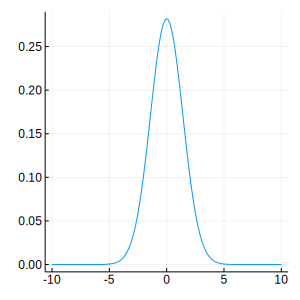

In [3]:
# test
f= gauss_pdf(;m=0.,σ2=2.)
x= range(-10,stop=10,length=100)
plot(x,f.(x),size=(300,300),label="")

In [4]:
# 2
struct Brownian
    Δ      # sampling stepsize
    Tmin  # initial time
    Tmax  # final time
    B0    # initial value
    σ2    # variance
end

In [5]:
#test
B = Brownian(.01,0.,1.,0.,1.)
B.Δ,B.Tmin,B.Tmax,B.B0,B.σ2 

(0.01, 0.0, 1.0, 0.0, 1.0)

In [6]:
using LaTeXStrings
using Plots
pyplot()

Plots.PyPlotBackend()

In [7]:
function sample(B::Brownian)
    # Generates a trajectories of the brownian motion B
    # returns a trajectory on [B.Tmin,B.Tmax]
   
    delta2 = B.σ2 
    dt = B.Δ

    # Initial condition.
    x = B.B0

    # Number of iterations to compute.
    n = Int(modf((B.Tmax - B.Tmin)/dt)[2])
    trajectory=zeros(1,n)
    trajectory[1]= B.B0
    # Iterate to compute the steps of the Brownian motion.
    for k in range(2, stop = n)
        x = x + randn()*sqrt(delta2*dt)
        trajectory[k] = x
    end
    return trajectory
end

function draw(B::Brownian ; nb_traj=100,enveloppe=true)
    # Plots trajectories of the brownian motion
    # nb_traj: number of trajectories to be plot
    # enveloppe: plots the enveloppe at B0+(+/-)3std
   
    #plot(reshape(sample(B),(100,)))
    trajectories=zeros(100,100)
    
    for i=1:nb_traj
        trajectories[:,i]=(reshape(sample(B),(100,1)))
        #trajectories[i,:]=sample(B)
    end 
    t=1:100
    fig1=plot(t,trajectories,legend=false)
   
    positive_env = 0
    negative_env = 0
    if enveloppe == true
        for k in range(1, stop = Int((B.Tmax - B.Tmin)/B.Δ)-1)
            x = 3*sqrt(B.σ2*k*B.Δ)
            positive_env  = [positive_env  x]
            negative_env  = [negative_env  -x]
        end
        fig1=plot!(t,reshape(positive_env,(100,1)),legend=false)
        fig1=plot!(t,reshape(negative_env,(100,1)),legend=false)
    end

end

draw (generic function with 1 method)

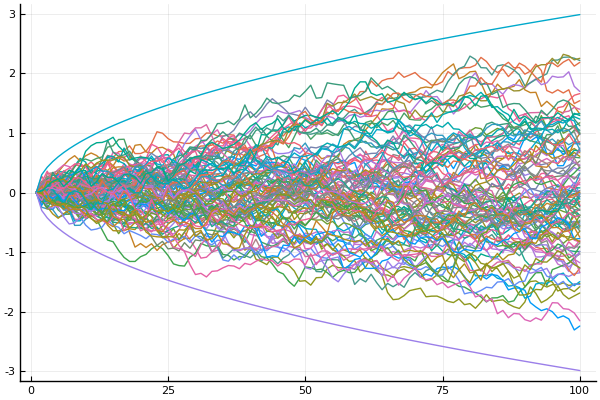

In [8]:
draw(B;nb_traj=100)

In [9]:
function hist(B ; nb_traj=1000, t= :Nan)
    # Plots the histogram at t from nb_traj trajectories
    # of the Brownian motion together with the
    # theoretical distribution
    trajectories=zeros(100,nb_traj)
    for i=1:nb_traj
        trajectories[:,i]=(reshape(sample(B),(100,1)))
        #trajectories[i,:]=sample(B)
    end
    index = Int((t-B.Tmin)/B.Δ)
    slice = trajectories[index,:]
    histogram(slice)
    f= gauss_pdf(;m=0.,σ2=B.σ2*index*B.Δ)
    x= range(-10,stop=10,length=100)
    plot!(x,f.(x)*1000,size=(300,300),label="")
end

hist (generic function with 1 method)

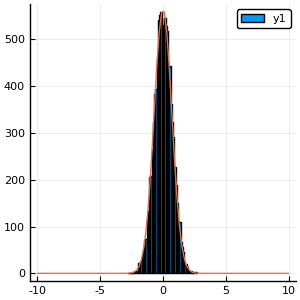

In [10]:
# 3
hist(B ; nb_traj=10^4, t=.5)

In [11]:
# 4

# Black-Scholes model
# Equation dX_t = rX_tdt + aX_tdB_t, with r=-1 et a=1
#----------------------------------------------------
r,a,X0  = -1.,1.,1.

function black_scholes_trajectory(t,Bt;r=-1.,a=1.,X0=1.)
    # returns sampling instants and samples
    # of a Black-holes trajectory
    # t:  sampling instants
    # Bt: brownian motion trajectory
    # r:  drift coefficient
    # a:  diffusion coefficient 
    # X0: initial value
    # Bt:  input brownian motion trajectory
    
    return X0*exp((r - (1/2)*a^2)t + a*Bt)
    
    
    
end

black_scholes_trajectory (generic function with 1 method)

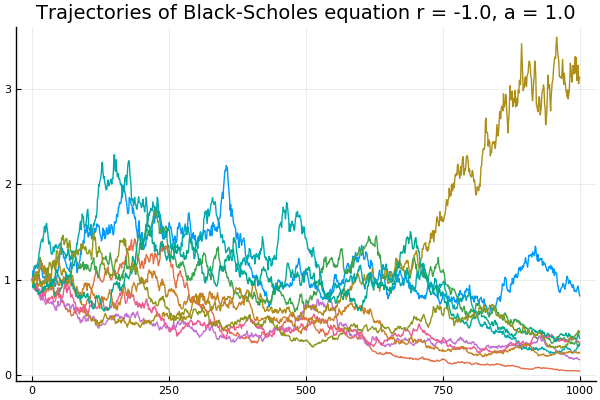

In [12]:
# test 
B = Brownian(.001,0.,1.,0.,1.)
p = plot()

for _ =1:10
    Bt = sample(B)
    count = Int((B.Tmax-B.Tmin)/B.Δ)
    X = zeros(count)
    for i in range(1, stop=count)
        X[i] = black_scholes_trajectory((i-1)*B.Δ, Bt[i])  
    end
    t = range(1,stop=count)
    p    = plot!(t,X,label="")
end
p = title!("Trajectories of Black-Scholes equation r = $r, a = $a")

In [13]:
# 5

struct model
   r
   a 
end

In [14]:
#m = model((t,x)->r*x,(t,x)->a*x,(t,x)->a)
m = model(-1.,1.)

model(-1.0, 1.0)

In [15]:
function integrate(m::model,t,Bt;X0=0, method="Euler", count=1000)
    # Returns the trajectory of a stochastic differential equations
    # t:  sampling instant
    # Bt: input brownian motion trajectory
    # X0: initial value
    # method: 'Euler', 'Milstein' or 'Runge_Kutta_1.5'
    # output: trajectory X of the SDE
    X = X0
    X_old = X0
    for i in range(2, stop=count)
        ΔBt = Bt[i] -Bt[i-1]
        if method == "Euler"
            X_new  = X_old + m.r*X_old*t + m.a*X_old*ΔBt
        elseif method == "Milstein"
            X_new  = X_old + m.r*X_old*t + m.a*X_old*ΔBt + (1/2)*(m.a)^2*((ΔBt)^2-t)
        elseif method == "Runge_Kutta_1.5"
            X_new  = X_old + m.r*X_old*t + m.a*X_old*ΔBt + (1/2)*(m.a)*(m.r*X_old*t + m.a*X_old*sqrt(t))*((ΔBt)^2-t)/sqrt(t)
        else 
            println("No methode corresponding")
        end
        X=[X X_new]
        X_old=X_new
    end
    return reshape(X,(count,)) 
end

integrate (generic function with 1 method)

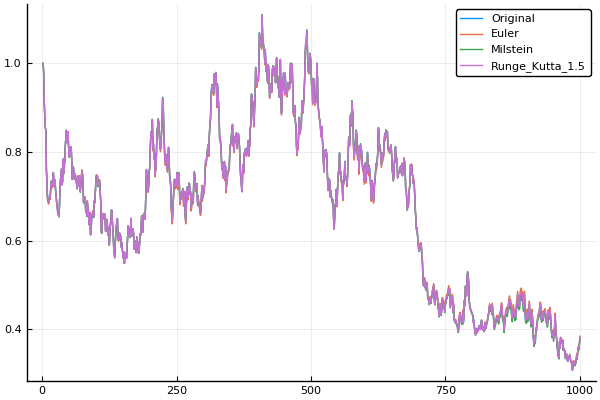

In [16]:
# Figures
Bt=sample(B) #1000 ps
t=.001
X_E=integrate(m::model,t,Bt;X0=1,method="Euler", count=1000)
X_M=integrate(m::model,t,Bt;X0=1,method="Milstein", count=1000)
X_RK=integrate(m::model,t,Bt;X0=1,method="Runge_Kutta_1.5", count=1000)
X_O = zeros(1000)
for i in range(1, stop=1000)
    X_O[i] = black_scholes_trajectory((i-1)*B.Δ, Bt[i])  
end

p = plot()
t = range(1,stop=1000)
p = plot!(t,X_O,label="Original")
p = plot!(t,X_E,label="Euler")
p = plot!(t,X_M,label="Milstein")
p = plot!(t,X_RK,label="Runge_Kutta_1.5")

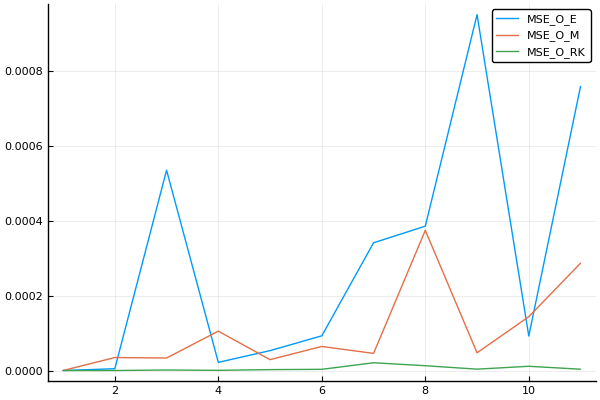

In [17]:
using Statistics: var

function MSE(x,y)
    return (x-y)^2
    
end 

MSE_O_E = 0
MSE_O_M = 0
MSE_O_RK = 0
for i in range(0.001, stop=0.01, step= 0.001)
    B = Brownian(i,0.,1.,0.,1.)
    Bt=sample(B)
    t = B.Δ
    count = Int(modf((B.Tmax-B.Tmin)/B.Δ)[2])
    X_E=integrate(m::model,t,Bt;X0=1,method="Euler", count = count)
    X_M=integrate(m::model,t,Bt;X0=1,method="Milstein", count = count)
    X_RK=integrate(m::model,t,Bt;X0=1,method="Runge_Kutta_1.5", count = count)
    
    X_O = zeros(count)
    for i in range(1, stop=count)
        X_O[i] = black_scholes_trajectory((i-1)*B.Δ, Bt[i])  
    end
    MSE_O_E = [MSE_O_E sum(MSE.(X_O, X_E))/count]
    MSE_O_M = [MSE_O_M sum(MSE.(X_O, X_M))/count]
    MSE_O_RK = [MSE_O_RK sum(MSE.(X_O, X_RK))/count]
end

MSE_O_E = reshape(MSE_O_E, (11,))
MSE_O_M = reshape(MSE_O_M, (11,))
MSE_O_RK = reshape(MSE_O_RK, (11,))
p = plot()
p = plot!(MSE_O_E,label="MSE_O_E")
p = plot!(MSE_O_M,label="MSE_O_M")
p = plot!(MSE_O_RK,label="MSE_O_RK")

Comment: From the image above, in this case, we can conclude that among these three numerical methods of approximation, Runge_Kutta_1.5 has the best performance and Euler is the worst among them.

-------

# <span style="color:#00B8DE">II - Parameter estimation for SDEs (lab 5&6)</span>

Let us consider the following SDE:
$$
dX_t=b(X_t)dt+\theta\sigma(X_t)dB_t\quad (1)
$$
a regularly sampled trajectory of which is observed at instants $t_i$. let $X_i=X_{t_i}$ ($i=1,\ldots,n$) 
denote observation variables $x_i,…,x_n$ corresponding observations. We shall assume that functions $b(x)$ and
$\sigma(x)$ are known but that $\theta$ is unknown 
 and changes at a given, instant that we want to estimate.

1 - Denoting by $\Delta$ the sampling period, supply the discretized version of (1) for Euler sampling method.

2 - We define the normalized increments as
$$
Z_i=\theta \dfrac{B_{i+1}−B_i}{\sqrt \Delta}\quad (2)
$$
Express $Z_i$ in terms of observation variables  Xi and give their distribution.

3 - Let $k$ denote the index value in $\{2,\ldots,n−1\}$ from which the value of $\theta$ 
changes. Let $\theta_1$ denote the value taken by $\theta$ until the time $\tau$ corresponding to $k$
and $\theta_2$ the value it takes after this instant. Compute maximum likelihood estimators of $\theta_1^2$ and $\theta_2^2$ as a function of $\tau$.

4 - Then check that the maximum likelihood estimator of the position $k$ of system transition is given by 
$\hat{k}=\arg\min_k D_k$, with
$$
D_k=k\log\dfrac{S_k}{k}+(n−k)\log\dfrac{S_n−S_k}{n−k}\quad (3)
$$
and $S_k=\sum^k_{i=1}Z^2_i$.

5 - As an example, we consider the Cox-Ingersoll-Ross processus with equation
$$
dX_t=(a−bX_t)dt+θ\sqrt{X_t}dBt \quad (4)
$$
This model has been used first to model population growth. The solution is given by
$$
X_t=X_0+\dfrac a b (1−e^{−bt})+\theta\int_0^te^{b(u−t)}\sqrt{X_u}dB_u\quad (5)
$$
6 - Let $(a,b)=(5,2)$, $\tau=0.6$ and $(\theta_1,\theta_2)=(1,3)$. 
Plot a few trajectories of the process over $[0,1]$ with for instance $X_0=4$. 
To this end, you can discretize the solution (5) directly with a stepsize $\Delta=10^{−2}$.

7 - Plot the evolution of the decision variable $D_k$ with $k$ for several simulated  trajectories.

8 - Estimate $\tau$ and $(\theta_1,\theta_2)$ for these trajectories and plot the sequence of values obtained.

9 - In the case where $b(x)$ and $\sigma(x)$ are unknown, we can rewrite the model in the form 
$dX_t=b(X_t)dt+\theta dB_t$. Then we can estimate $b(x)$ via a non parametric kernel method and then apply the method considered above to detect the instant when the diffusion term of the system changes. Implementez this approach and apply it to the observed trajectory. Study the values obtained for the estimates of $\tau$ and $(\theta_1,\theta_2)$. Comments ?

1.
$$
X_{k+1}=X_k+b(X_k)\Delta+\sigma(X_t)*\Delta(B_k)
$$

2.

$$
Z_i \sim \mathcal{N}(0,\,\theta^{2})\,.
$$

$$
X_{k+1}=X_k+b(X_k)\Delta+\sigma(X_t){\sqrt\Delta}Z_k
$$
$$
Z =\frac{(X[2:end] - X[1:end-1] + drif.(X[1:end-1]*\Delta))}{sqrt(\Delta*X[1:end-1])}
$$
3.
$$
{\hat{\theta_1}^2} = \frac{S_k}{k}
$$
$$
{\hat{\theta_2}^2} = \frac{S_n-S_k}{n-k}
$$
$$
S_k=\sum^k_{i=1}Z^2_i
$$

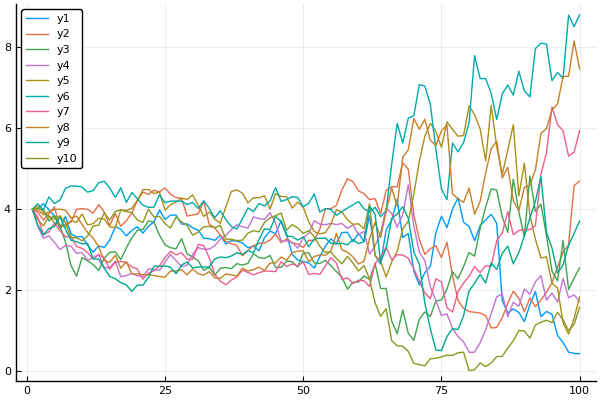

In [18]:
Tmin = 0
Tmax = 1
τ = 0.6
Δ =.01
k = Int((τ-Tmin)/Δ)
n = Int((Tmax-Tmin)/Δ)
sita1=1
sita2=3
X0 = 4
a = 5
b = 2
#Function to generate the processus Cox-Ingersoll-Ross
function CIR(Zi, n, a ,b, Δ, X0=4)
    X = X0
    X_old = X0
    for i in range(2, stop=n)
        X_new = X_old + (a-b*X_old)*Δ + sqrt(X_old)*sqrt(Δ)*Zi[i-1]
        X=[X X_new]
        X_old=X_new
    end
    return X
end

#Generatation of 10 trajectories of the processus Cox-Ingersoll-Ross
X_histo = zeros(100,10)
for m in range(1, stop=10) 
    Zi_1= randn(k)*sqrt(sita1^2)
    Zi_2= randn(n-k)*sqrt(sita2^2)
    Zi = [Zi_1 ; Zi_2]
    X_histo[:,m] = CIR(Zi, n, a ,b ,Δ)
end
plot(X_histo)

In [19]:
# 6 - trajectories of Cox-Ingersoll-Ross process
# note that in some cases numerical errors can lead
# to negative values
#------------------------------------------------

#Containers to store predicted values  
Dk_histo = zeros(98,10)
K_histo = zeros(10,)
sita1_histo = zeros(10,)
sita2_histo = zeros(10,)

for m in range(1, stop=10)
    X_ex= X_histo[:,m]
    #Reconstruction Zi from trajectories of processus CIR
    Zi = (X_ex[2:end]- X_ex[1:end-1]+(a.-b*X_ex[1:end-1])*Δ)./sqrt.(Δ*X_ex[1:end-1])
    Sn = sum(Zi.^2)
    histo = zeros(n-2)
    K_pre = 0
    D_min = 700
    for i in range(2, stop=n-1)
        Sk = sum(Zi[1:i].^2)
        Dk = i*log(Sk/i) + (n-i)*log((Sn-Sk)/(n-i))
        if(Dk==-Inf)
            continue
        end
        #Store K_predict when Dk is the minimum
        if(Dk<D_min)
            D_min = Dk
            K_pre = i        
        end
        histo[i-1] = Dk
    end
    Sk_pre = sum(Zi[1:K_pre].^2)
    #Prediction of sita_1 and sita_2
    sita_1_pre = sqrt(Sk_pre/K_pre)
    sita_2_pre = sqrt((Sn - Sk_pre)/(n-K_pre))
    Dk_histo[:,m] = histo
    K_histo[m] = K_pre
    sita1_histo[m] = sita_1_pre 
    sita2_histo[m] = sita_2_pre 
    
end 

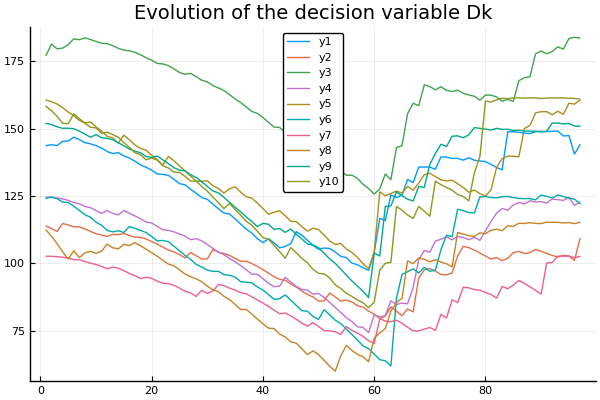

In [20]:
plot(Dk_histo[1:97,:], title="Evolution of the decision variable Dk")

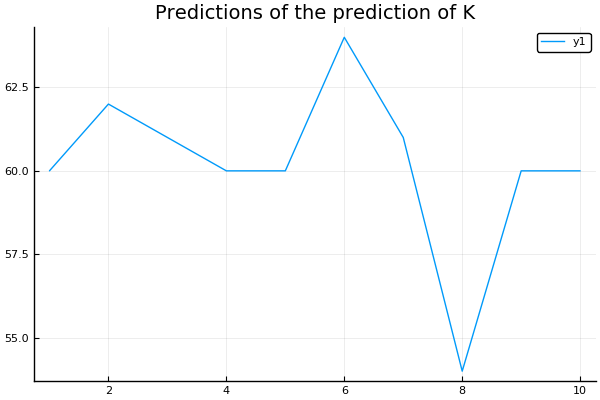

In [21]:
plot(K_histo, title="Predictions of the prediction of K")

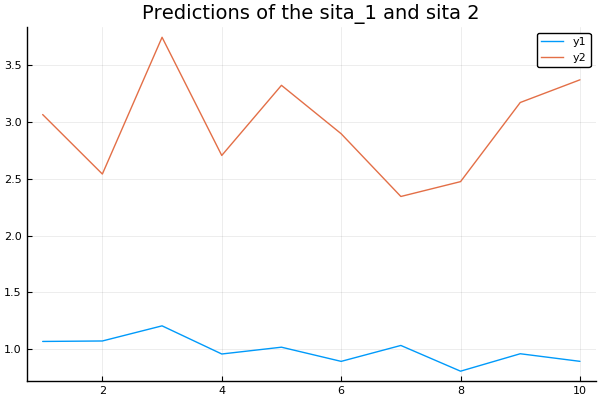

In [22]:
plot(sita1_histo, title="Predictions of the sita_1 and sita 2")
plot!(sita2_histo)

In [23]:
# 9 - Estimation with unknown drift
#---------------------------------------
X_ori = X_histo[:,1]
sigma_cha=var(X_ori)
h_n = sigma_cha^2*n^(-0.2)

K_hn= gauss_pdf(;m=0.,σ2=h_n^2)

#Kernel method to approximate drift function
function b_predict(x, X, n, Δ, K_hn)
    result = zeros(n-1)
    for i in range(1, stop=n-1)
        nominateur = 0
        denominateur = 0
        for i in range(1, stop=n-1)
            nominateur+=K_hn(x[i]-X[i])*(X[i+1]-X[i])
            denominateur+=K_hn(x[i]-X[i])
        end
        result[i] = nominateur/(denominateur*Δ)
    end
    return result
end

b_predict (generic function with 1 method)

In [24]:
Dk_histo = zeros(98,10)
K_histo = zeros(10,)
sita1_histo = zeros(10,)
sita2_histo = zeros(10,)

for m in range(1, stop=10)
    X_ex= X_histo[:,m]
    #Generatiton of Zi from trajectories of CIR with non parametric method
    Zi = (X_ex[2:end]- X_ex[1:end-1]+b_predict(X_ex[1:end-1], X_ex, n, Δ, K_hn)*Δ)./sqrt.(Δ*X_ex[1:end-1])
    Sn = sum(Zi.^2)
    histo = zeros(n-2)
    K_pre = 0
    D_min = 700
    for i in range(2, stop=n-1)
        Sk = sum(Zi[1:i].^2)
        Dk = i*log(Sk/i) + (n-i)*log((Sn-Sk)/(n-i))
        if(Dk==-Inf)
            continue
        end
        if(Dk<D_min)
            D_min = Dk
            K_pre = i        
        end
        histo[i-1] = Dk
    end
    Sk_pre = sum(Zi[1:K_pre].^2)
    sita_1_pre = sqrt(Sk_pre/K_pre)
    sita_2_pre = sqrt((Sn - Sk_pre)/(n-K_pre))
    Dk_histo[:,m] = histo
    K_histo[m] = K_pre
    sita1_histo[m] = sita_1_pre 
    sita2_histo[m] = sita_2_pre 
    
end 

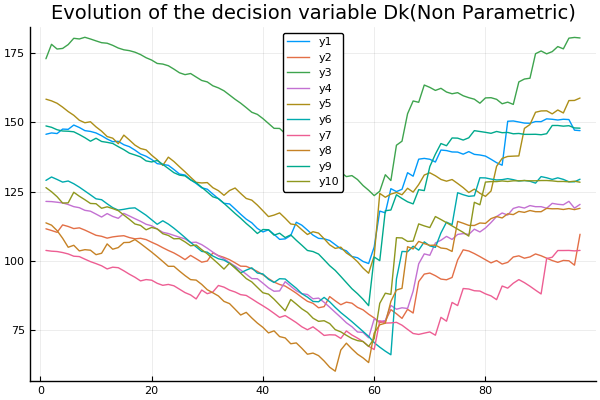

In [25]:
plot(Dk_histo[1:97,:], title="Evolution of the decision variable Dk(Non Parametric)")

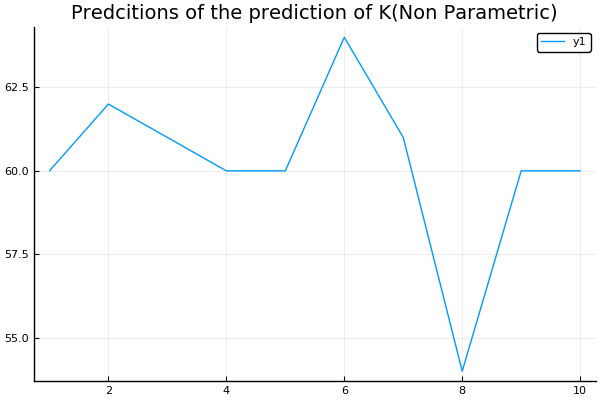

In [26]:
plot(K_histo, title="Predcitions of the prediction of K(Non Parametric)")

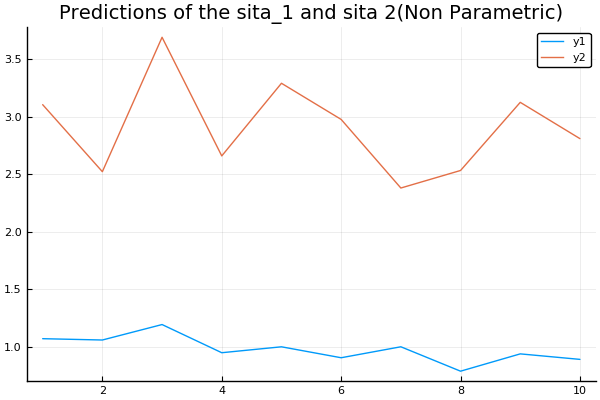

In [27]:
plot(sita1_histo, title="Predictions of the sita_1 and sita 2(Non Parametric)")
plot!(sita2_histo)